# Using LayoutLM for sequence classification

[**LayoutLM**](https://arxiv.org/abs/1912.13318) developed by Microsoft Research Asia has become a very popular model for document understanding task such as sequence or token classification. In contrast to other language models even the simplest version heavily relies not only on the word/token itself but also on the positional information of words in the document. For scans this requires to perform OCR as a pre-processing steps making the task for training or experimenting with different OCR tools, but also for evaluating as well as putting the whole framework into production a lot more challenging. 

In this notebook we are going to show how to train and evaluate a document classifier using LayoutLM and how to run predictions with the model. We divide the task into the following steps:

- First generate a sub-dataset from the very large and popular [**RVL-CDIP**](https://huggingface.co/datasets/rvl_cdip) dataset. In order to make the dataset ready for training we need to generate features. That means we OCR the selected documents and generate .json files with bounding boxes and detected words. The dataset has a document type label for each scan. We use the label as ground truth for training the classifier.   

- We build a **deepdoctection** dataset for the sub-dataset. We wrap the dataset into a special class to create training, eval and test split.

- We download pre-trained base models from the Huggingface hub. 

- Next we setup the environment for running the training script. We choose a metric and define the evaluation setup. Then we run the training script. The train script itself uses the default trainer from the transformer library with standard configuration. 

- After training has finished we run a evaluation on the test split. 

- At the last step we show how to build a **deepdoctection** pipeline with an OCR model and how to use trained model in practise. 

This notebook is not intended as an introduction into the **deepdoctection**. We are therefore sparse with explanation and assume that the user will look into the [**documentation**](https://deepdoctection.readthedocs.io/en/latest/) for further information regarding functions, classes and methods. 

In [ ]:
import os
import deepdoctection as dd

## Generating a RVL-CDIP sub dataset with words and bounding box features

To OCR some specific documents we first build a **deepdoctection** pipeline with an OCR model. We use the [**docTr library by mindee**](https://github.com/mindee/doctr) that has a concept to break the OCR task into two parts: text line detection and text recognition.   

In [2]:
def get_doctr_pipe():
    text_line_predictor = dd.DoctrTextlineDetector()
    layout = dd.ImageLayoutService(text_line_predictor,to_image=True, crop_image=True)
    text_recognizer = dd.DoctrTextRecognizer()
    text = dd.TextExtractionService(text_recognizer, extract_from_roi="WORD")
    analyzer = dd.DoctectionPipe(pipeline_component_list=[layout, text])

    return analyzer

Next, we use the RVL-CDIP dataset from the **deepdoctection** library. This step requires the full dataset to be downloaded. The full dataset has more than 300k samples with 16 different labels. We choose three labels "FORM","INVOICE" and "BUDGET" and select around 1000 samples from each label. 

In [ ]:
# We do not know the distribution of each category. In order have all labels equally weighted we stream at most 1K
# samples with each label individually, pass them to the OCR-pipeline and save the OCR result for every image in 
# a folder with one JSON file.   

rvlcdip = dd.get_dataset("rvl-cdip")
rvlcdip.dataflow.categories.filter_categories({"BUDGET"})
pipeline = get_doctr_pipe()

df = rvlcdip.dataflow.build(split="train", load_image=True)
df = pipeline.analyze(dataset_dataflow=df, output="image")
dd.dataflow_to_json(df, "/path/to/rvlcdip", single_files=True, max_datapoints=1000, save_image=True,
                    save_image_in_json=False, highest_hierarchy_only=True)

rvlcdip = dd.get_dataset("rvl-cdip")
rvlcdip.dataflow.categories.filter_categories({"INVOICE"})
pipeline = get_doctr_pipe()

df = rvlcdip.dataflow.build(split="train", load_image=True)
df = pipeline.analyze(dataset_dataflow=df, output="image")
dd.dataflow_to_json(df, "/path/to/rvlcdip", single_files=True, max_datapoints=1000, save_image=True,
                    save_image_in_json=False, highest_hierarchy_only=True)

rvlcdip = dd.get_dataset("rvl-cdip")
rvlcdip.dataflow.categories.filter_categories({"FORM"})
pipeline = get_doctr_pipe()

df = rvlcdip.dataflow.build(split="train", load_image=True)
df = pipeline.analyze(dataset_dataflow=df, output="image")
dd.dataflow_to_json(df, "/path/to/rvlcdip", single_files=True, max_datapoints=1000, save_image=True,
                    save_image_in_json=False, highest_hierarchy_only=True)

## Defining a dataset 

Having generated a dataset with features and labels at "/path/to/rvlcdip" we now copy the folder into the **deepdoctection** cache and define a dataset for sequence classification. For convenience we register the dataset.

In [2]:
@dd.dataset_registry.register("rvl")
class RVL(dd.DatasetBase):

    @classmethod
    def _info(cls) -> dd.DatasetInfo:
        return dd.DatasetInfo(name="rvl", description="", license="", url="", splits={}, type="SEQUENCE_CLASSIFICATION")

    def _categories(self) -> dd.DatasetCategories:
        return dd.DatasetCategories(init_categories=[dd.names.C.FORM, dd.names.C.INV,dd.names.C.BU])

    def _builder(self) -> "RvlBuilder":
        return RvlBuilder(location="rvlcdip")


class RvlBuilder(dd.DataFlowBaseBuilder):

    def build(self, **kwargs) -> dd.DataFlow:
        load_image = kwargs.get("load_image", False)

        ann_files_dir = self.get_workdir()
        image_dir = self.get_workdir() / "image"

        df = dd.SerializerFiles.load(ann_files_dir,".json")
        df = dd.MapData(df, dd.load_json)
        categories = self.categories.get_categories(name_as_key=True)

        @dd.curry
        def map_to_img(dp, cats):
            dp = dd.Image.from_dict(**dp) # no heavy conversion necessary.
            dp.file_name= dp.file_name.replace(".tif",".png")
            dp.location = image_dir / dp.file_name
            if not os.path.isfile(dp.location): # when creating the dataset some image could not be generated and we have to skip these
                return None
            if not len(dp.annotations): # Some samples were rotated where OCR was not able to recognize text. No text -> no features
                return None
            sub_cat = dp.summary.get_sub_category(dd.names.C.DOC)
            sub_cat.category_id = cats[sub_cat.category_name]
            return dp
        df = dd.MapData(df, map_to_img(categories))

        def _maybe_load_image(dp):
            if load_image:
                dp.image = dd.load_image_from_file(dp.location)
            return dp

        df = dd.MapData(df, _maybe_load_image)

        return df

## Downloading the base LayoutLM base model

For convenience we already registered the models that have to be chosen and which are available at Huggingface hub. We use `layoutlm-base-uncased`. This model does not have any head yet and the top head will be specified by the task as well as by the number of labels within the training script just before the training starts.  

In [ ]:
dd.ModelDownloadManager.maybe_download_weights_and_configs("microsoft/layoutlm-base-uncased/pytorch_model.bin") 

## Defining the model

For those who might wonder why we do not use the very handy transformer `.from_pretained` methods and rather setup a model by passing a config file and weights: All models trainable by the **deepdoctection** framework are build using a config file and specifying a path to the arefact. We don't want to deviate from this path here either. 

In [5]:
path_config_json = dd.ModelCatalog.get_full_path_configs("microsoft/layoutlm-base-uncased/pytorch_model.bin")
path_weights = dd.ModelCatalog.get_full_path_weights("microsoft/layoutlm-base-uncased/pytorch_model.bin")

## Gerating a split

Using the `MergeDataset` class we can load the dataset into memory and split it into a train, val and test set (similar to scikit-learns `train_test_split`) Specifying a ratio of 0.05 means that the train split will contain on average 90% of overall dataset with the remaining two splits sharing on average the last 10% equally. It does not mean that the train split contains exactly 90%!  

In [6]:
rvl = dd.get_dataset("rvl")

merge = dd.MergeDataset(rvl)
merge.buffer_datasets()
merge.split_datasets(ratio=0.1)

[0819 08:08.49 @base.py:218] INF Will use the same build setting for all dataflows
[0819 08:08:49 @common.py:558] [JoinData] Size check failed for the list of dataflow to be joined!


|                                                                                                                                                                                             |2983/?[00:00<00:00,50221.00it/s]
|                                                                                                                                                                                               |2862/?[00:16<00:00,169.94it/s]

[0819 08:09.06 @base.py:270] INF ___________________ Number of datapoints per split ___________________
[0819 08:09.06 @base.py:271] INF {'test': 148, 'train': 2565, 'val': 149}


## Training

We invoke `train_hf_layoutlm` to start fine-tuning the LayoutLM model for classification. We must tell the metric what attribute we want to evaluate, hence the reason for calling `set_categories`. 

We run the training scripts more or less we default arguments as specified by the Transformers `Trainer`. Arguments can be changed by passing a list of strings `argument=value` for `config_overwrite`. We choose `max_steps` of the training to be equal the size of the training split and `per_device_train_batch_size` to be 8.
When running with one machine this corresponds to run training for 8 epochs. We evaluate on small intervals. Adapt your parameters if you train with more machines or if you need to reduce batch_size because of memory constraints.

In [ ]:
dataset_train = merge
dataset_val = merge

metric = dd.get_metric("accuracy")
metric.set_categories(summary_sub_category_names="DOC_CLASS")

dd.train_hf_layoutlm(path_config_json,
                     dataset_train,
                     path_weights,
                     log_dir="/path/to/traindir",
                     dataset_val= dataset_val,
                     metric=metric,
                     pipeline_component_name="LMSequenceClassifierService")

## Tensorboard

Logging does not look very neat on the display of jupyter. You can start tensorboard tensorboard from a terminal


```sh
tensorboard --logdir /path/to/traindir
```

to get an overview of current learning rate, epoch, train loss and accuracy for the validation set

## Running evaluation on the test set

Configuration files and checkpoints are being saved in sub folders of `traindir`. We use them to run a final evaluation on the test split we haven't used yet. 

The training script already selects a tokenizer that is needed to convert the raw features, i.e. words into tokens. It also chooses the mapping framework that converts datapoints of internal **deepdoctection** image format into layoutlm features. 
The Evaluator however, has been designed to run evaluation on various tasks. Hence it needs a pipeline component. The pipeline component for language model sequence classification must be instatiated by choosing the layoutlm model, but also the right converter to generate layoutlm features from the intrinsic **deepdoctection** data model as well as the right tokenizer.

We only use Huggingface's fast tokenizer as it contains helpful additional outputs to generate LayoutLM inputs.  

In [9]:
from transformers import LayoutLMTokenizerFast

In [ ]:
path_config_json = "/path/to/traindir/checkpoint-2500/config.json"
path_weights = "/path/to/traindir/checkpoint-2500/pytorch_model.bin"

layoutlm_classifier = dd.HFLayoutLmSequenceClassifier(path_config_json,
                                                      path_weights,
                                                      merge.dataflow.categories.get_categories(as_dict=True))

tokenizer_fast = LayoutLMTokenizerFast.from_pretrained("microsoft/layoutlm-base-uncased")

pipe_component = dd.LMSequenceClassifierService(tokenizer_fast,layoutlm_classifier,dd.image_to_layoutlm_features)

evaluator = dd.Evaluator(merge,pipe_component,metric)

In [ ]:
evaluator.run(split="test")

We get an accuracy score of 0.89 on the test set.

```sh
[{'key': 'DOC_CLASS', 'val': 0.8851351351351351, 'num_samples': 148}]
```

## Building a pipeline to for production

In the final step we setup a complete pipeline for running the LayoutLM model. We use the same OCR framework as above and plug the LMSequenceClassifierService in a subsequent step into the pipeline.

In [16]:
def get_layoutlm_pipeline():
    text_line_predictor = dd.DoctrTextlineDetector()
    layout_component = dd.ImageLayoutService(text_line_predictor,to_image=True, crop_image=True)
    text_recognizer = dd.DoctrTextRecognizer()
    text_component = dd.TextExtractionService(text_recognizer, extract_from_roi="WORD")
    
    
    layoutlm_classifier = dd.HFLayoutLmSequenceClassifier(path_config_json,
                                                          path_weights,
                                                          {'1': 'FORM', '2': 'INVOICE', '3': 'BUDGET'})
    
    tokenizer_fast = LayoutLMTokenizerFast.from_pretrained("microsoft/layoutlm-base-uncased")
    layoutlm_component = dd.LMSequenceClassifierService(tokenizer_fast,
                                                        layoutlm_classifier,
                                                        dd.image_to_layoutlm_features)
    
    return dd.DoctectionPipe(pipeline_component_list=[layout_component, text_component, layoutlm_component])

## Running the pipeline

The last step is the traditional way to use **deepdoctection** pipelines. We use a subfolder of plain images of the `rvl` dataset just demonstrate how it works.

In [ ]:
path = "/path/to/.cache/rvlcdip/image"

doc_classifier = get_layoutlm_pipeline()

df = doc_classifier.analyze(path=path)
df_iter = iter(df)

In [21]:
from matplotlib import pyplot as plt

[0819 10:06.58 @doctectionpipe.py:101] INF processing 0000002151.png
[0819 10:06.59 @context.py:131] INF ImageLayoutService finished, 0.9468 sec.
[0819 10:07.00 @context.py:131] INF TextExtractionService finished, 0.9698 sec.
[0819 10:07.00 @context.py:131] INF LMSequenceClassifierService finished, 0.0321 sec.


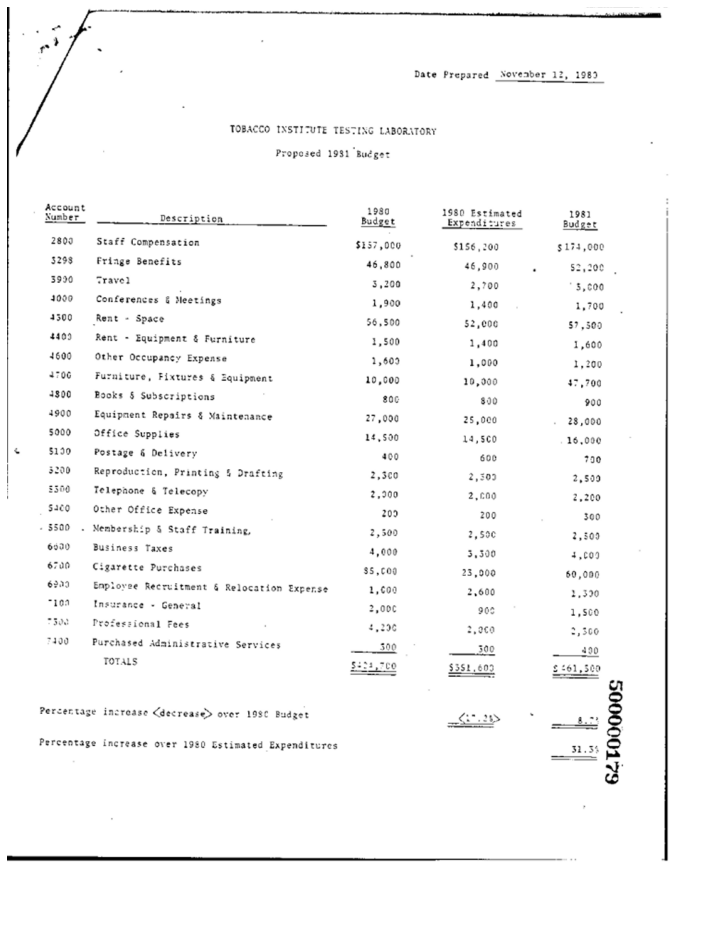

In [32]:
dp = next(df_iter)

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(dp.viz())

In [33]:
dp.document_type

'BUDGET'

In [34]:
dp=next(df_iter)

[0819 10:07.15 @doctectionpipe.py:101] INF processing 0000011684.png
[0819 10:07.16 @context.py:131] INF ImageLayoutService finished, 0.8708 sec.
[0819 10:07.16 @context.py:131] INF TextExtractionService finished, 0.0967 sec.
[0819 10:07.16 @context.py:131] INF LMSequenceClassifierService finished, 0.025 sec.


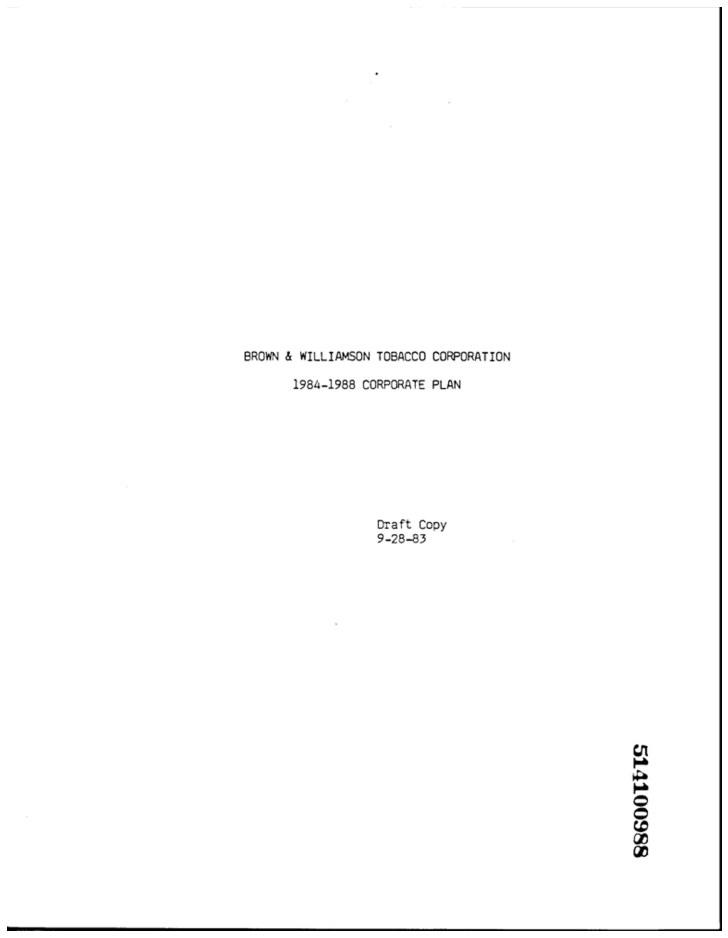

In [35]:
plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(dp.viz())

In [36]:
dp.document_type

'BUDGET'